In [12]:
from glob import glob
import re
import pandas as pd
from datasets import Dataset
from data import bool_remove
from datasets import load_from_disk
from rapidfuzz import process, fuzz
import numpy as np
import string
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [13]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    model_name="gpt-2", chunk_size=300, chunk_overlap=100
)

In [14]:
remove_punc = string.punctuation.replace('.','').replace(',','').replace("'",'').replace("(",'').replace("(",'')

In [15]:
filepath  = "raw\\placaatboek\\csvs\\*.csv" 
files = glob(filepath, recursive=True)

In [16]:
files

['raw\\placaatboek\\csvs\\PlakkaatboekDeel01_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel02_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel03_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel04_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel05_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel06_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel07_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel08_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel09_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel10_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel11_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel12_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel13_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel14_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel15_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel16_lines.csv',
 'raw\\placaatboek\\csvs\\PlakkaatboekDeel17_lines.csv']

In [17]:
maanden = [
    "louwmaand", "sprokkelmaand", "lentmaand", "grasmaand", "blooimand", "zomermaand", 
    "hooimaand", "oogstmaand", "herfstmaand", "wijnmaand", "slaghtmaand", "wintermaand",
    "januari", "februari", "maart", "april", "mei", "juni",
    "juli", "augustus", "september", "oktober", "november", "december",
    "Januari", "Februari", "Maart", "April", "Mei", "Juni",
    "Juli", "Augustus", "September", "Oktober", "November", "December",
    'Louwmaand', 'Sprokkelmaand', 'Lentmaand', 'Grasmaand', 'Blooimand', 'Zomermaand',
    'Hooimaand', 'Oogstmaand', 'Herfstmaand', 'Wijnmaand', 'Slaghtmaand', 'Wintermaand'
]

def fuzzy_matching(word, threshold=70):
    match1, score1, _ = process.extractOne(word, maanden, scorer=fuzz.ratio)
    return score1 >= threshold and len(word) >= 3

In [18]:
# Extract legislation
dfs = []
full_len = []
filtered_len = []
for file in files:
    df = pd.read_csv(file, encoding='utf-8', converters={'points': pd.eval}).fillna('')
    
    # use knn classifier to determine if page heading (year, name of author)
    if 'preds' not in df.columns:
        df['preds'] = bool_remove(df["points"]) 
        df.to_csv(file, encoding='utf-8')
    print(file)        
    name = file.split('_')[0].replace('.csv','').split("\\")[-1]
    print(f'On {name}')
    ### Extracting legislation with year and dates
    legislations = []
    years = []
    dates = []
    
    curr_year = ''
    prev_year = ''
    curr_date = '' # each date means new legislation
    prev_date = ''
    legislation = ''

    for index, row in df.iterrows():
        
        if row.preds == 1 or row.boolHasLegisYear:
            try:
                curr_year = re.findall(r"[0-9]{4}", row.line)[0] # the first four numbers are the year
                if prev_year == '':
                    prev_year = curr_year
            except:
                continue
        else:        
            if "REGISTER" in row.line:
                break # stop at the register at the end (index of book)
            if not row.line.isupper() and not row.line.isalpha(): 
                # the titles on the top of the page (for the author, not always spelt correctly) are all caps
               
                if row.boolHasLegisDate: # there is a new legislation  
                         
                    try: # check if new date exists
                        splits = row.line.split('.')
                        # remove None
                        dates_ = list(filter(None, re.split('(\d{1,})|\s', splits[0])))
                        curr_date = ' '.join(dates_)
                        if prev_date == '':
                            prev_date = curr_date
                            
                        if dates_[-1].istitle() and len(legislation.split(' ')) > 20: # if date exists (check month capitalized) and if current legislation is long enough
                            # chunking
                            legislation_ = text_splitter.split_text('.'.join(legislation.split('.')[1:]).strip())
                            for l in legislation_:
                                legislations.append(l) # removing date
                                dates.append(prev_date)
                                years.append(prev_year)
                            # New legislation start
                            legislation = row.line + ' '
                            prev_year = curr_year
                            prev_date = curr_date
                        else:                                         # otherwise keep adding
                            legislation = legislation + row.line + ' '
                            
                    except:
                        continue
                        
                else:
                    legislation = legislation + row.line + ' '
                # print(legislation)
                # print()
                
    # save the last one
    legislation_ = text_splitter.split_text('.'.join(legislation.split('.')[1:]).strip())
    for l in legislation_:
        legislations.append(l) # removing date
        dates.append(curr_date)
        years.append(curr_year)
    
    # print(len(legislations), len(dates), len(years))
    legisdf = pd.DataFrame({"legislation": legislations, "year": years, "date": dates, "book": [name]*len(legislations)}).dropna()
    legisdf = legisdf[~legisdf['legislation'].str.len().eq(1)]
    legisdf = legisdf[legisdf['legislation'].str.strip().astype(bool)]
    print(f"Full length: {len(legisdf)}")
    full_len.append(len(legisdf))
    # remove rows which dont have a year (check for 4 len int) and a date (fuzzy matching)
    legisdf = legisdf[legisdf['date'].apply(fuzzy_matching)]
    legisdf = legisdf[np.where((legisdf['year'].str.len()==4) & (legisdf['year'].str.isdigit()), True, False)]
    print(f"Filtered length: {len(legisdf)}")
    filtered_len.append(len(legisdf))
    dfs.append(legisdf)

raw\placaatboek\csvs\PlakkaatboekDeel01_lines.csv
On PlakkaatboekDeel01
Full length: 1925
Filtered length: 1549
raw\placaatboek\csvs\PlakkaatboekDeel02_lines.csv
On PlakkaatboekDeel02
Full length: 1884
Filtered length: 1586
raw\placaatboek\csvs\PlakkaatboekDeel03_lines.csv
On PlakkaatboekDeel03
Full length: 2063
Filtered length: 1614
raw\placaatboek\csvs\PlakkaatboekDeel04_lines.csv
On PlakkaatboekDeel04
Full length: 1969
Filtered length: 1367
raw\placaatboek\csvs\PlakkaatboekDeel05_lines.csv
On PlakkaatboekDeel05
Full length: 2399
Filtered length: 1788
raw\placaatboek\csvs\PlakkaatboekDeel06_lines.csv
On PlakkaatboekDeel06
Full length: 2453
Filtered length: 1749
raw\placaatboek\csvs\PlakkaatboekDeel07_lines.csv
On PlakkaatboekDeel07
Full length: 2431
Filtered length: 1704
raw\placaatboek\csvs\PlakkaatboekDeel08_lines.csv
On PlakkaatboekDeel08
Full length: 3023
Filtered length: 2184
raw\placaatboek\csvs\PlakkaatboekDeel09_lines.csv
On PlakkaatboekDeel09
Full length: 1994
Filtered lengt

In [19]:
import pickle

with open("raw/placaatboek/all_vers", 'wb') as b:
    pickle.dump(dfs, b)

In [20]:
# Filter text (remove charecters, -, \neg are already removed)
for df in dfs:
    df['legislation'] = df['legislation'].apply(lambda x: x.lstrip().rstrip().replace('- ', '').translate(remove_punc))

In [21]:
with open("raw/placaatboek/all_vers_preprocessed", 'wb') as b:
    pickle.dump(dfs, b)

In [22]:
# check if dates are correct:
dfs[2].iloc[5]

legislation    Bepaling, dat het verbod tegen den verkoop van...
year                                                        1678
date                                                18 Februarij
book                                          PlakkaatboekDeel03
Name: 5, dtype: object

In [23]:
print(len(filtered_len))

17


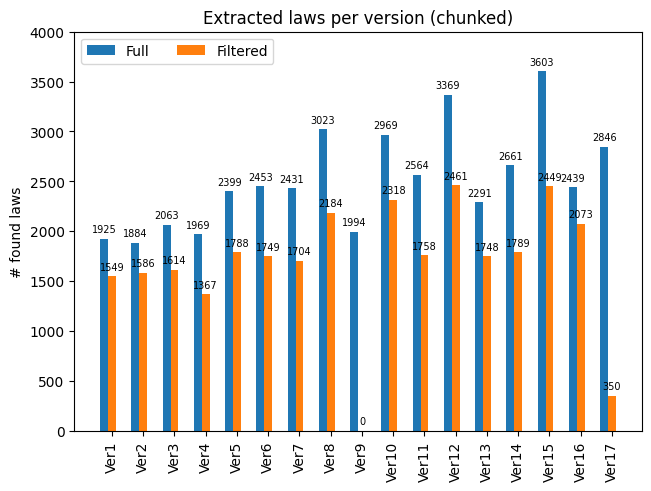

In [27]:
import matplotlib.pyplot as plt
import numpy as np

names = [f"Ver{i+1}" for i in range(17)]
lengths = {"Full":full_len, "Filtered":filtered_len}

x = np.arange(len(names))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in lengths.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, size=7)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# found laws')
ax.set_title('Extracted laws per version (chunked)')
ax.set_xticks(x + width, names, rotation=90)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 4000)

plt.show()